In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from model import AdderNet, AdderNet2_0
from Train import model_training
from quantization_encoder import Quant
from quantization_decoding import Quant_decode

In [2]:
# Hyper parameters
epoch_losses = []
train_loss_list = []
lr = 0.001
epochs = 200
train_batch_size = 256
test_batch_size = 128
in_channels = 3
out_channels = 16
kernel_size = 3

# Model device assignment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdderNet().to(device)

In [ ]:
# Define transformation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010))
])

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010))
])

# Load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=8)

# Load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=0)

# Define the class names for reference
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# Training AdderNet model on Cifar10
train_model = model_training(model, lr, trainloader, epochs)
training_loss = train_model.forward(device)

In [ ]:
# Visualization of training results
plt.plot(training_loss, linewidth=2, c='r')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss of Addernet Model")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

model.eval()
with torch.no_grad():
    number_correct = 0
    samples = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, prediction = torch.max(outputs, 1)
        samples += labels.size(0)
        number_correct += (prediction == labels).sum().item()

accuracy = (number_correct / samples) * 100.0
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Save the model
torch.save(model.state_dict(), 'AdderNet_model.pth')
print("Model saved as 'AdderNet_model.pth'")


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_state_dict = torch.load('AdderNet_model.pth', map_location=device)
fixed_state_dict = {}

def remap_key(key: str) -> str:
    """Map original checkpoint keys to the correct AdderNet naming."""
    new_key = key.replace('module.', '')  # Remove DataParallel prefix

    # Top-level conv and batchnorm
    if new_key.startswith('conv1.') or new_key.startswith('bn1.') or new_key.startswith('fc.') or new_key.startswith('bn2.'):
        return new_key

    # Process residual layers
    for layer_num in [1, 2, 3]:
        prefix = f'layer{layer_num}.'
        if new_key.startswith(prefix):
            rest = new_key[len(prefix):]  # everything after 'layerX.'

            # If next is block index, e.g. '0.conv1.adder'
            if rest[0].isdigit():
                block_num = rest[0]
                rest_after_block = rest[2:]  # skip "0."

                # Handle downsample case
                if rest_after_block.startswith('downsample.'):
                    ds_rest = rest_after_block[len('downsample.'):]
                    if ds_rest.startswith('0.'):
                        return f'layer{layer_num}.downsample_adder.{ds_rest[2:]}'
                    elif ds_rest.startswith('1.'):
                        return f'layer{layer_num}.downsample_bn.{ds_rest[2:]}'

                # Otherwise: normal residual block conv/bn
                rest_after_block = rest_after_block.replace('conv1.', 'adder1.')
                rest_after_block = rest_after_block.replace('conv2.', 'adder2.')
                return f'layer{layer_num}.blocks.{block_num}.{rest_after_block}'

    # If nothing matches, just return as is
    return new_key

# Apply the mapping
for key, value in model_state_dict.items():
    fixed_key = remap_key(key)
    fixed_state_dict[fixed_key] = value

params = list(fixed_state_dict.items())
n_params = len(params)

Using device: cuda


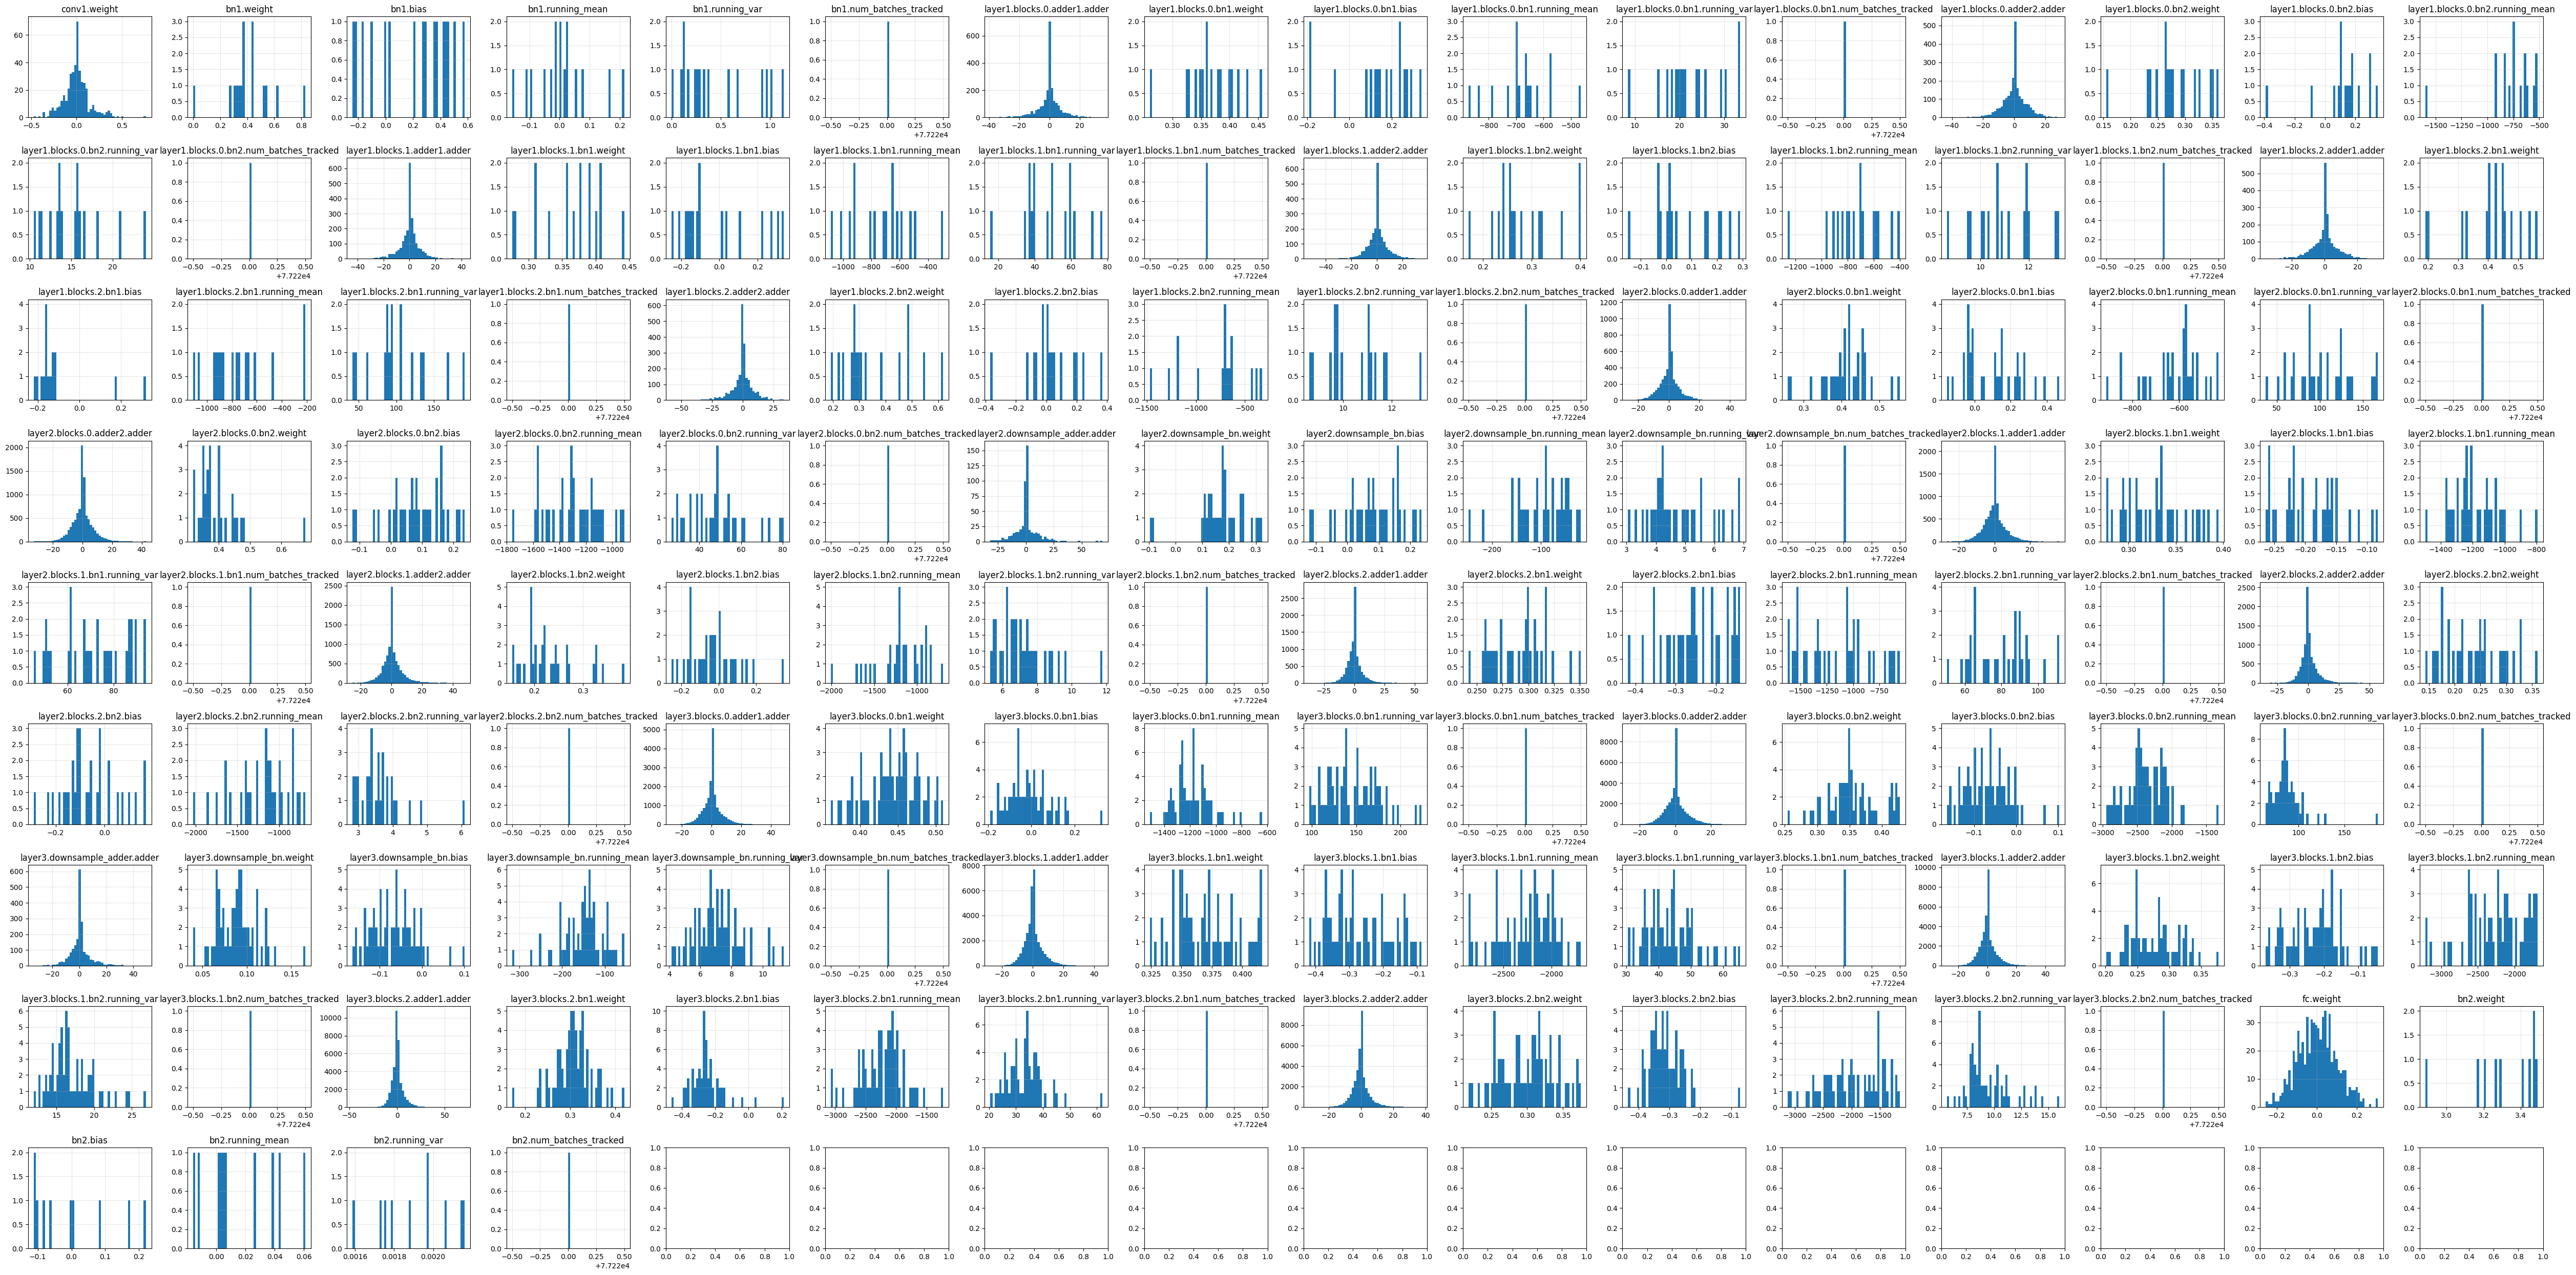

In [9]:
n_cols = 16  # 16 columns
n_rows = (n_params + n_cols - 1) // n_cols  # 8 rows for 128 params

# Create subplots with larger figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, 25))
axes = axes.flatten()

# Plot each parameter
for i, (name, tensor) in enumerate(params):
    values = tensor.cpu().numpy().flatten()
    axes[i].hist(values, bins=50)
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

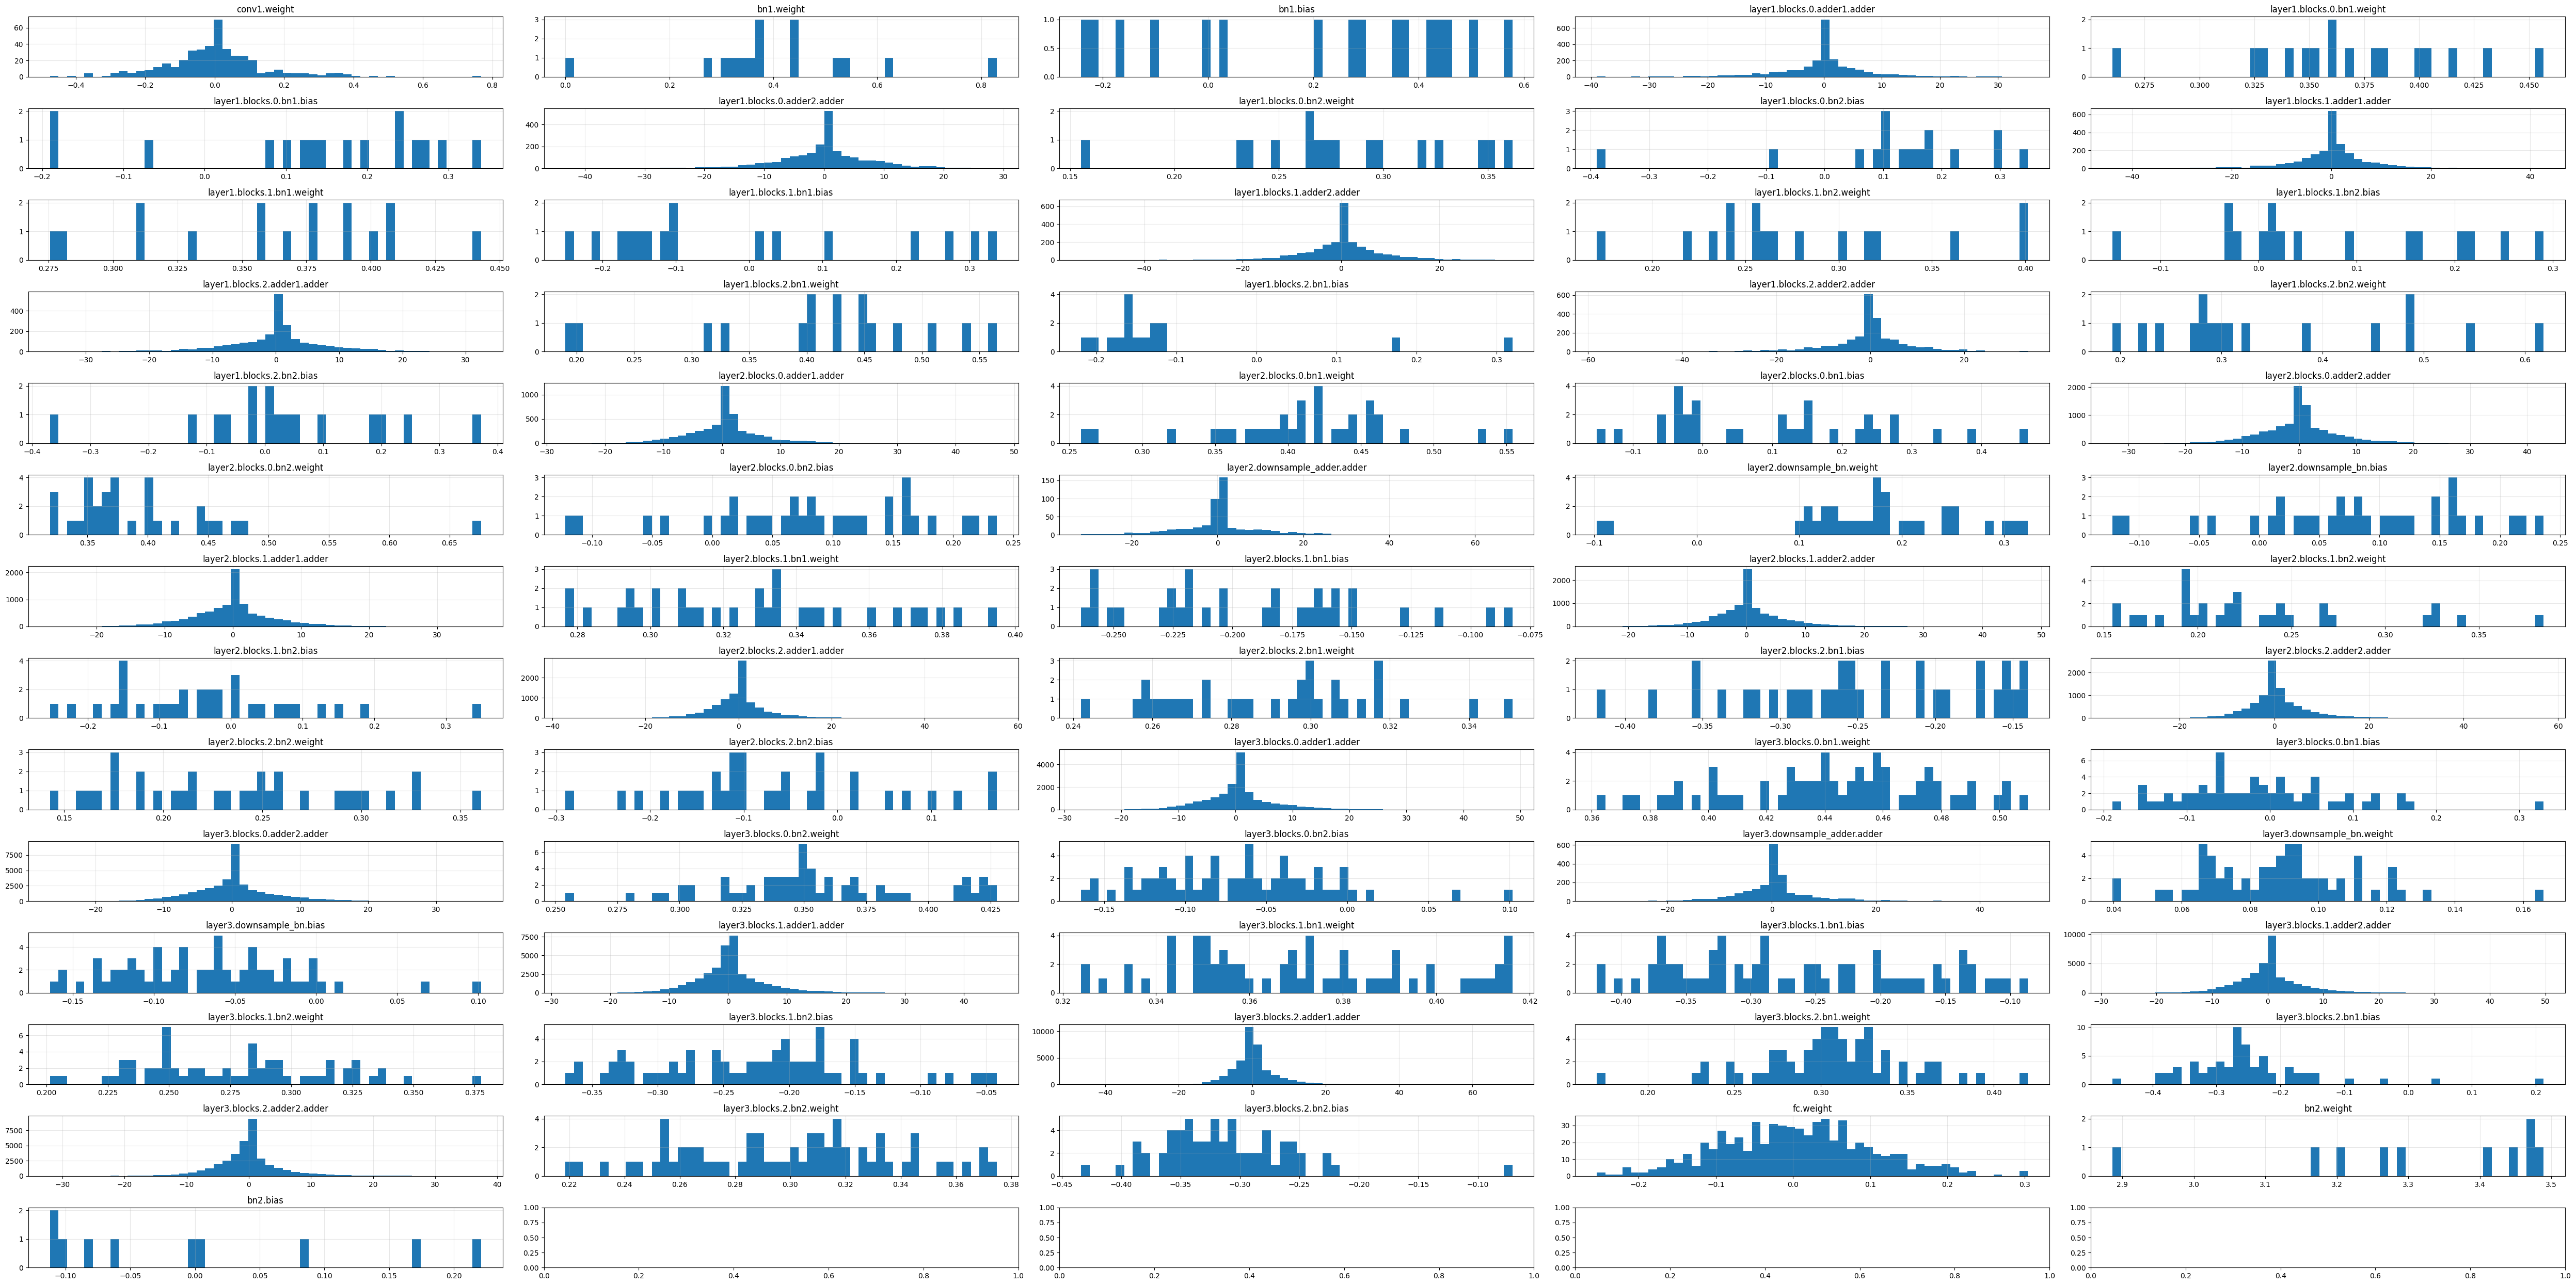

In [10]:
filtered_params = []
for name, tensor in params:
    # Include if name contains: weight, bias, adder
    if any(keyword in name.lower() for keyword in ['weight', 'bias', 'adder']):
        filtered_params.append((name, tensor))

n_params = len(filtered_params)

n_cols = 5  # 5 columns
n_rows = (n_params + n_cols - 1) // n_cols  # 13 rows for 65 params

# Create subplots with larger figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, 25))
axes = axes.flatten()

# Plot each parameter
for i, (name, tensor) in enumerate(filtered_params):
    values = tensor.cpu().numpy().flatten()
    axes[i].hist(values, bins=50)
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [11]:
# Quantization of weight tensors
quant_acc = []
quant_error = []
bit_array = [16, 14, 12, 10, 8, 6, 4, 3, 2]
activations_dict = {}

for i, bits in enumerate(bit_array):
  activations_dict[bits] = {
    'input_activation': None,
    'prelayer_activation': None,
    'layer1_activation': None,
    'layer2_activation': None,
    'layer3_activation': None
  }
  quant_dict = {}
  max_error = 0.0

  for name, weight_tensor in params:
    quantized_tensor, scale = Quant.symmetric_quantization(weight_tensor, bits=bits)
    fp32_tensor, error = Quant_decode.dequant(scale, quantized_tensor, weight_tensor)
    quant_dict[name] = fp32_tensor.to(device)
    max_error = max(max_error, error)

  quant_model = AdderNet().to(device)
  quant_model.load_manual_weights(quant_dict)
  quant_model.eval()

  print(f"Testing {bits}-bit quantization")
  with torch.no_grad():
      number_correct = 0
      samples = 0
      first_batch = True
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = quant_model(images, save_activations=True)

          _, prediction = torch.max(outputs, 1)
          samples += labels.size(0)
          number_correct += (prediction == labels).sum().item()

          if first_batch:
            for name, activation in quant_model.activations.items():
              activations_dict[bits][name] = activation.cpu().clone()
            first_batch = False

  del quant_model
  torch.cuda.empty_cache() if torch.cuda.is_available() else None
  quant_acc.append((number_correct / samples) * 100.0)
  quant_error.append(max_error)


Testing 16-bit quantization
Testing 14-bit quantization
Testing 12-bit quantization
Testing 10-bit quantization
Testing 8-bit quantization
Testing 6-bit quantization
Testing 4-bit quantization
Testing 3-bit quantization
Testing 2-bit quantization


In [12]:
# AOQ of weight tensors
quant_acc_2_0 = []
quant_error_2_0 = []
bit_array = [16, 14, 12, 10, 8, 6, 4, 3, 2]
activations_dict2_0 = {}

for i, bits in enumerate(bit_array):
  activations_dict2_0[bits] = {
    'input_activation_2.0': None,
    'prelayer_activation_2.0': None,
    'layer1_activation_2.0': None,
    'layer2_activation_2.0': None,
    'layer3_activation_2.0': None
  }

  # Create a fresh copy of the state dict for this bit width
  quantized_state_dict = {k: v.clone() for k, v in fixed_state_dict.items()}

  max_val = 2.5
  Max_A = 2**(bits-1) - 1      # Maximum value: 127 for bits=8
  Max_B = -1 * 2**(bits-1)     # Minimum value: -128 for bits=8
  delta = max_val / (2**(bits-1) - 1)

  print(f"\nProcessing {bits}-bit quantization with FBR. Delta Val: {delta}")

  x_tensor = quantized_state_dict['bn1.weight']
  xq_tensor = x_tensor / delta
  quantized_state_dict['bn1.weight'] = xq_tensor

  x_tensor = quantized_state_dict['bn1.bias']
  xq_tensor = x_tensor / delta
  quantized_state_dict['bn1.bias'] = xq_tensor


  for name in quantized_state_dict.keys():
      if name.startswith('layer'):
          if name.endswith('adder'):
              w_tensor = quantized_state_dict[name]
              wq = torch.round(w_tensor/delta)
              wq_clamp = torch.clamp(wq, max=Max_A, min=Max_B)
              quantized_state_dict[name] = wq_clamp
              quantized_state_dict[name] = wq
              bias_tensor = (wq - wq_clamp).abs()
              bias_sum = torch.sum(bias_tensor, dim=(1,2,3))
          if name.endswith('running_mean'):
              m_tensor = quantized_state_dict[name]
              mq = torch.round(m_tensor/delta)
              mq = m_tensor/delta
              quantized_state_dict[name] = mq + bias_sum
              quantized_state_dict[name] = mq
          if name.endswith('bias'):
              x_tensor=quantized_state_dict[name]
              xq_tensor = x_tensor/delta
              quantized_state_dict[name] = xq_tensor

  quantized_state_dict['fc.weight']=quantized_state_dict['fc.weight']*delta

  quant_model = AdderNet2_0(num_classes=10).to(device)
  quant_model.load_manual_weights(quantized_state_dict)
  quant_model.eval()

  print(f"Testing {bits}-bit quantization AdderNet2.0")
  with torch.no_grad():
      number_correct = 0
      samples = 0
      first_batch = True
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = quant_model(images, save_activations=True)

          _, prediction = torch.max(outputs, 1)
          samples += labels.size(0)
          number_correct += (prediction == labels).sum().item()

          if first_batch:
            for name, activation in quant_model.activations.items():
              activations_dict2_0[bits][name] = activation.cpu().clone()
            first_batch = False

  accuracy = (number_correct / samples) * 100.0
  print(f"  Accuracy: {accuracy:.2f}%")

  del quant_model
  torch.cuda.empty_cache() if torch.cuda.is_available() else None
  quant_acc_2_0.append(accuracy)


Processing 16-bit quantization with FBR. Delta Val: 7.629627368999298e-05
Testing 16-bit quantization AdderNet2.0
  Accuracy: 91.82%

Processing 14-bit quantization with FBR. Delta Val: 0.0003052130387010133
Testing 14-bit quantization AdderNet2.0
  Accuracy: 91.82%

Processing 12-bit quantization with FBR. Delta Val: 0.0012212994626282364
Testing 12-bit quantization AdderNet2.0
  Accuracy: 91.82%

Processing 10-bit quantization with FBR. Delta Val: 0.004892367906066536
Testing 10-bit quantization AdderNet2.0
  Accuracy: 91.83%

Processing 8-bit quantization with FBR. Delta Val: 0.01968503937007874
Testing 8-bit quantization AdderNet2.0
  Accuracy: 91.64%

Processing 6-bit quantization with FBR. Delta Val: 0.08064516129032258
Testing 6-bit quantization AdderNet2.0
  Accuracy: 90.83%

Processing 4-bit quantization with FBR. Delta Val: 0.35714285714285715
Testing 4-bit quantization AdderNet2.0
  Accuracy: 22.28%

Processing 3-bit quantization with FBR. Delta Val: 0.8333333333333334
Test

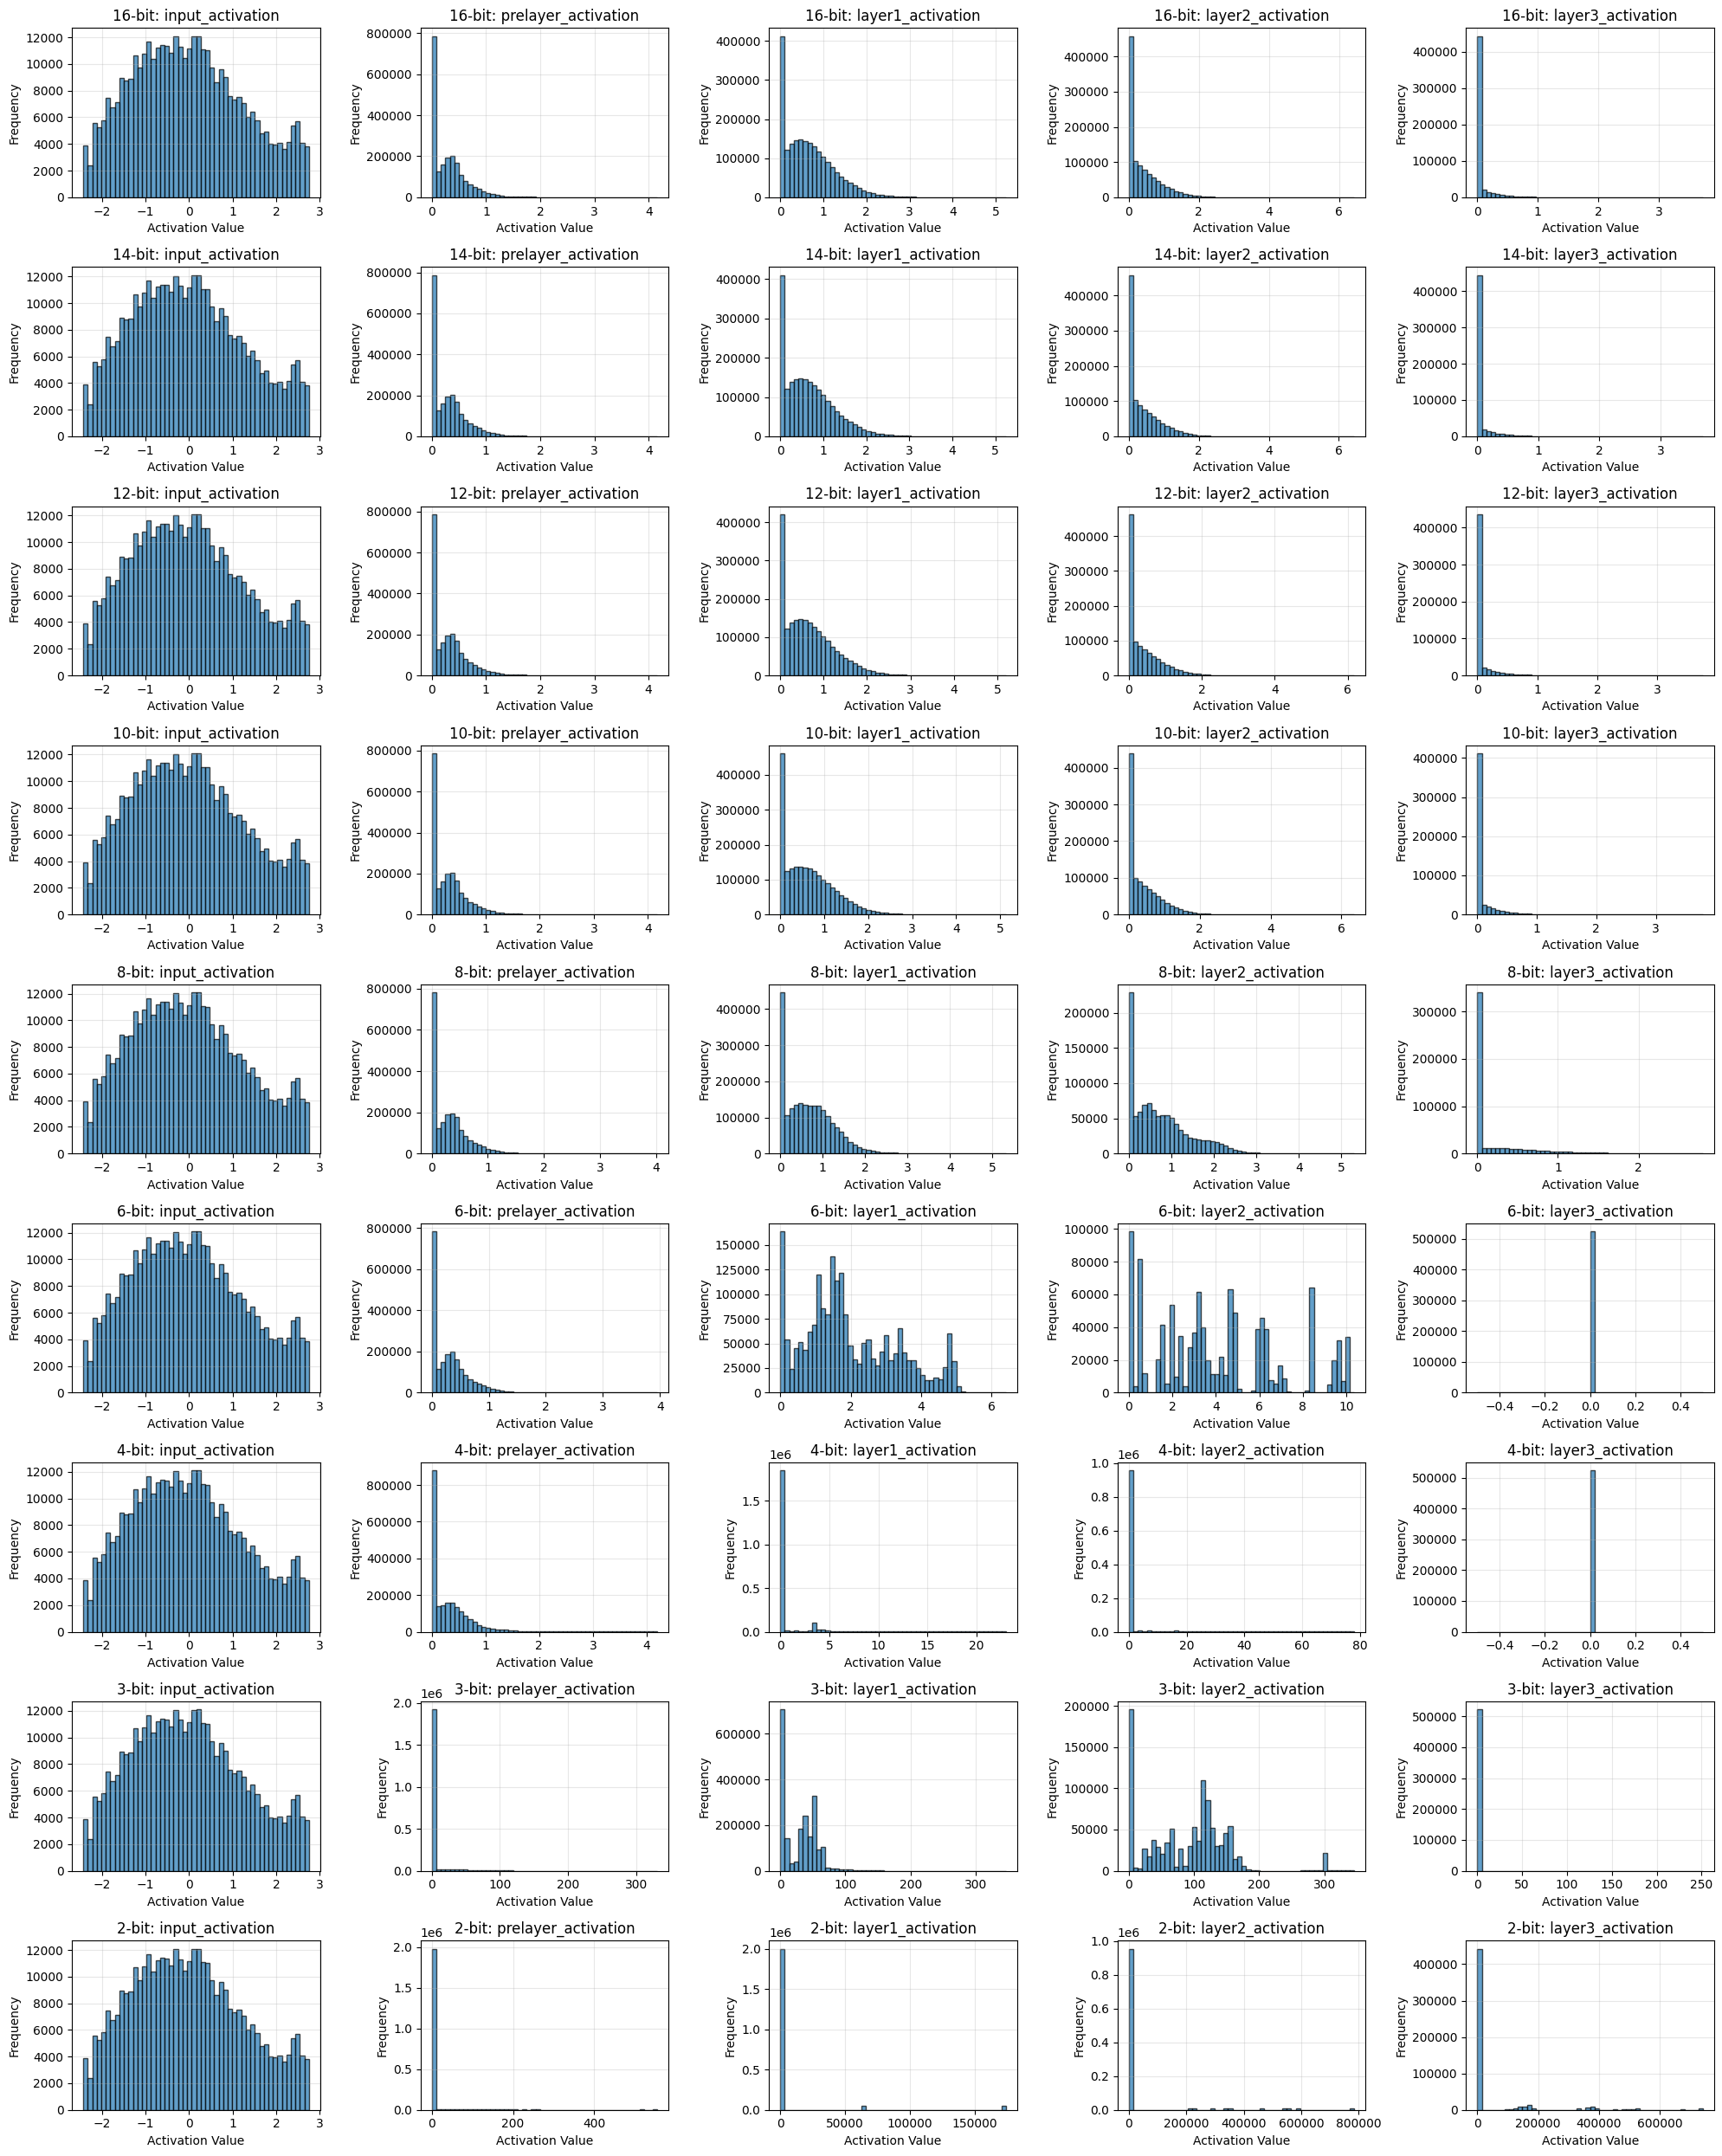

In [13]:
activation_names = list(activations_dict[16].keys())
num_bits = len(bit_array)
num_activations = len(activation_names)

fig, axes = plt.subplots(num_bits, num_activations, figsize=(20, 25))

for i, bits in enumerate(bit_array):
  for j, name in enumerate(activation_names):
    ax = axes[i, j]

    act_values = activations_dict[bits][name].cpu().flatten()

    ax.hist(act_values, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'{bits}-bit: {name}')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

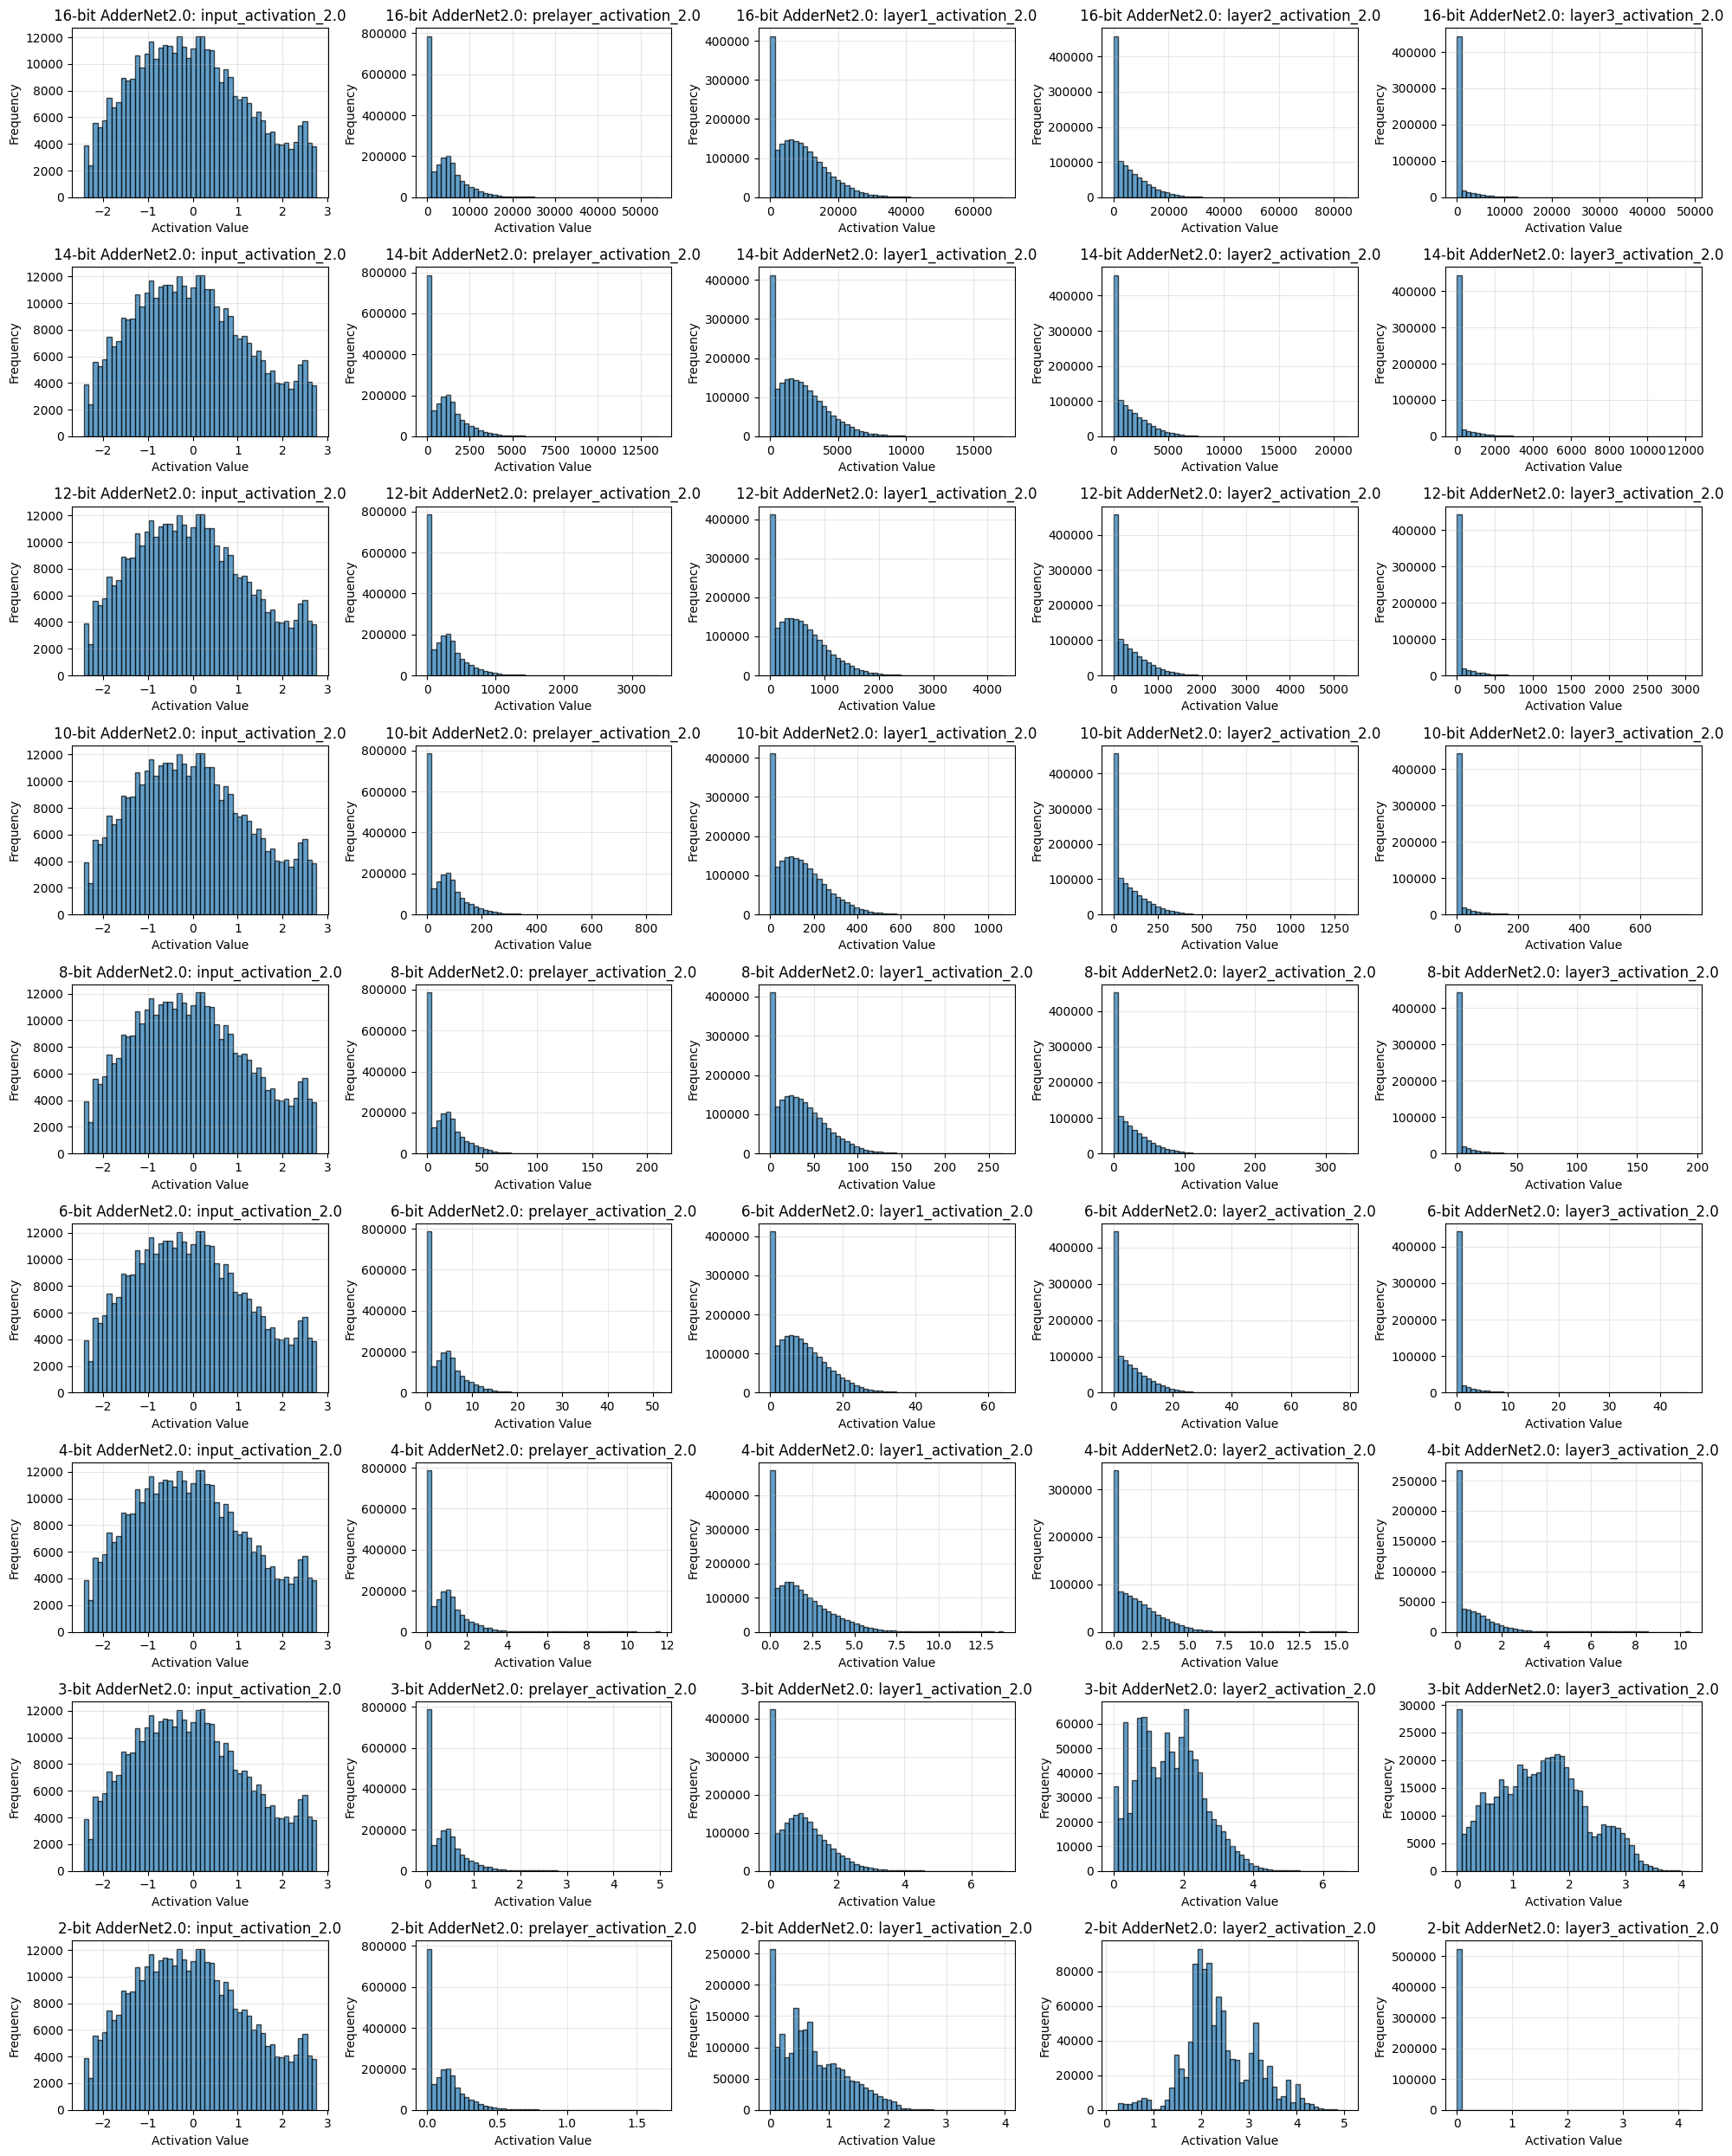

In [14]:
activation_names = list(activations_dict2_0[16].keys())
num_bits = len(bit_array)
num_activations = len(activation_names)

fig, axes = plt.subplots(num_bits, num_activations, figsize=(20, 25))

for i, bits in enumerate(bit_array):
  for j, name in enumerate(activation_names):
    ax = axes[i, j]

    act_values = activations_dict2_0[bits][name].cpu().flatten()

    ax.hist(act_values, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'{bits}-bit AdderNet2.0: {name}')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

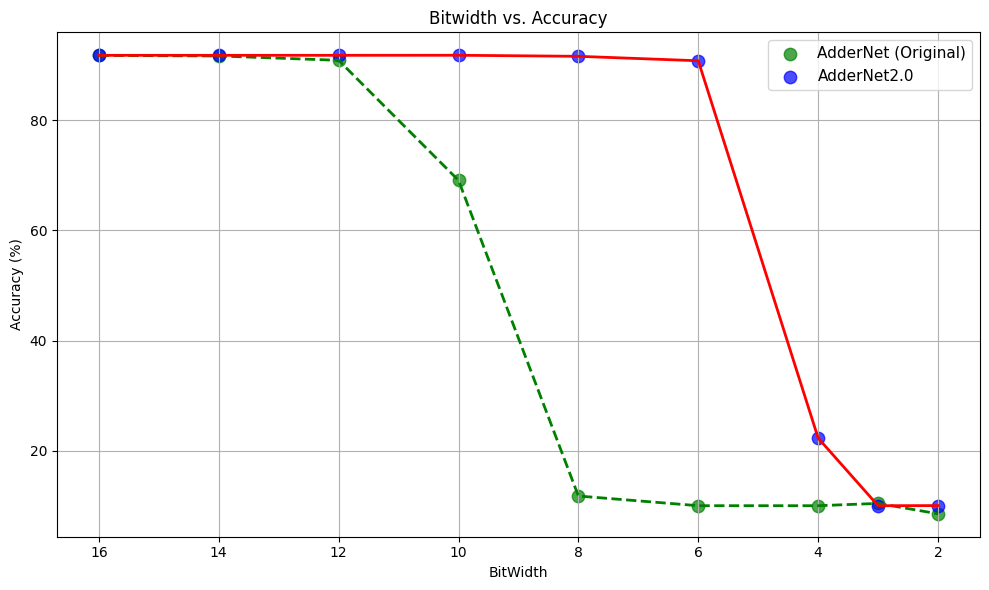

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(bit_array, quant_acc, s=80, c='green', alpha=0.7, label='AdderNet (Original)')
ax.plot(bit_array, quant_acc, linewidth=2, c='green', linestyle='--')
ax.scatter(bit_array, quant_acc_2_0, s=80, c='blue', alpha=0.7, label='AdderNet2.0')
ax.plot(bit_array, quant_acc_2_0, linewidth=2, c='r')

ax.set_title('Bitwidth vs. Accuracy')
ax.set_xlabel('BitWidth')
ax.set_ylabel('Accuracy (%)')
ax.legend(fontsize=11)
ax.grid(True)
ax.invert_xaxis()

plt.tight_layout()
plt.show()

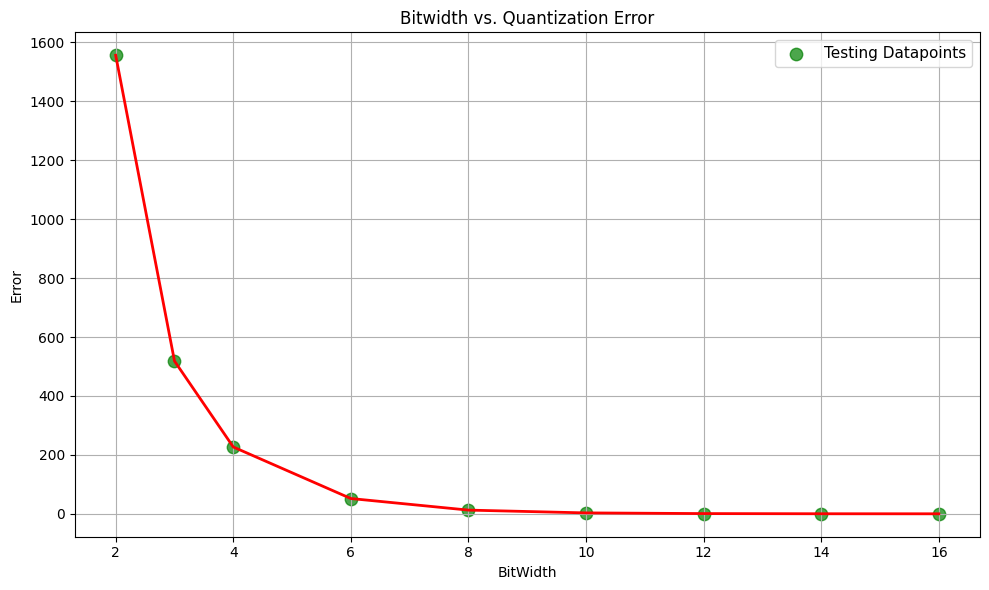

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(bit_array, quant_error, s=80, c='green', alpha=0.7, label='Testing Datapoints')
ax.plot(bit_array, quant_error, linewidth=2, c='r')
ax.set_title('Bitwidth vs. Quantization Error')
ax.set_xlabel('BitWidth')
ax.set_ylabel('Error')
ax.legend(fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()